In [1]:
!nvidia-smi

Mon Mar 24 01:07:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             53W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/ostris/ai-toolkit
!mkdir -p /content/dataset

fatal: destination path 'ai-toolkit' already exists and is not an empty directory.


In [3]:
!cd ai-toolkit && git submodule update --init --recursive && pip install -r requirements.txt

  Cloning https://github.com/huggingface/diffusers (to revision 363d1ab7e24c5ed6c190abb00df66d9edb74383b) to /tmp/pip-req-build-lg2vrndb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-lg2vrndb
  Running command git rev-parse -q --verify 'sha^363d1ab7e24c5ed6c190abb00df66d9edb74383b'
  Running command git fetch -q https://github.com/huggingface/diffusers 363d1ab7e24c5ed6c190abb00df66d9edb74383b
  Running command git checkout -q 363d1ab7e24c5ed6c190abb00df66d9edb74383b
  Resolved https://github.com/huggingface/diffusers to commit 363d1ab7e24c5ed6c190abb00df66d9edb74383b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
from google.colab import userdata
from huggingface_hub import login

hf_token = userdata.get('hf_token')
login(token=hf_token)

In [5]:
import os
import sys
sys.path.append('/content/ai-toolkit')
from toolkit.job import run_job
from collections import OrderedDict
from PIL import Image
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [6]:
genre_templates = {
    4: [  # Landscapes
        "an impressionist landscape painting, nature scene, {details}, loose brushstrokes, atmospheric lighting",
        "impressionist outdoor scene, natural landscape, {details}, vibrant colors, painterly style",
        "plein air landscape painting, impressionist style, {details}, natural light, visible brushwork"
    ],
    6: [  # Portraits
        "an impressionist portrait painting, {details}, expressive brushstrokes, character study",
        "impressionist style portrait, {details}, atmospheric rendering, painterly technique",
        "character portrait in impressionist style, {details}, loose brushwork, natural lighting"
    ],
    1: [  # Urban Scenes
        "impressionist cityscape, urban scene, {details}, atmospheric perspective, loose brushwork",
        "city view in impressionist style, {details}, vibrant street life, painterly technique",
        "urban landscape painting, impressionist style, {details}, dynamic composition"
    ],
    9: [  # Still Life
        "impressionist still life painting, {details}, loose brushstrokes, natural lighting",
        "still life arrangement in impressionist style, {details}, painterly technique",
        "intimate still life scene, impressionist style, {details}, vibrant colors"
    ]
}

details_by_genre = {
    4: [  # Landscapes
        "rolling hills and meadows", "tranquil water reflections", "sunlit garden path",
        "autumn trees", "coastal scenery", "flowering fields", "misty morning",
        "sunset colors", "rural countryside", "peaceful riverside"
    ],
    6: [  # Portraits
        "elegant figure", "contemplative pose", "casual pose in natural light",
        "figure in garden setting", "person in period dress", "candid moment",
        "figure by window light", "character study", "person in natural setting"
    ],
    1: [  # Urban Scenes
        "busy street life", "city buildings", "cafe terrace",
        "boulevard scene", "urban park", "city square",
        "street market", "railway station", "harbor view"
    ],
    9: [  # Still Life
        "flowers in vase", "fruit arrangement", "table setting",
        "household objects", "garden flowers", "books and objects",
        "kitchen scene", "artist's studio items", "seasonal produce"
    ]
}

In [8]:
import numpy as np
print(np.__version__)

1.26.4


In [9]:
import os
import random
from datasets import load_dataset

def create_captions_for_dataset():
    # Load your dataset
    dataset = load_dataset("dolphinium/wikiart-impressionism-curated")

    # Create output directory
    os.makedirs("/content/dataset", exist_ok=True)

    # Process each image
    for idx, item in enumerate(dataset['train']):
        # Get image and genre
        image = item['image']
        genre_id = item['genre']

        # Save image
        image_filename = f"image_{idx:04d}.jpg"
        image.save(f"/content/dataset/{image_filename}")

        # Create caption
        template = random.choice(genre_templates[genre_id])
        details = random.choice(details_by_genre[genre_id])
        caption = template.format(details=details)

        # Save caption
        caption_filename = f"image_{idx:04d}.txt"
        with open(f"/content/dataset/{caption_filename}", 'w') as f:
            f.write(caption)

create_captions_for_dataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
from collections import OrderedDict

job_to_run = OrderedDict([
    ('job', 'extension'),
    ('config', OrderedDict([
        # this name will be the folder and filename name
        ('name', 'flux_1_dev_wikiart_impressionism'),
        ('process', [
            OrderedDict([
                ('type', 'sd_trainer'),
                # root folder to save training sessions/samples/weights
                ('training_folder', '/content/output'),
                # uncomment to see performance stats in the terminal every N steps
                #('performance_log_every', 1000),
                ('device', 'cuda:0'),
                # if a trigger word is specified, it will be added to captions of training data if it does not already exist
                # alternatively, in your captions you can add [trigger] and it will be replaced with the trigger word
                # ('trigger_word', 'image'),
                ('network', OrderedDict([
                    ('type', 'lora'),
                    ('linear', 16),
                    ('linear_alpha', 16)
                ])),
                ('save', OrderedDict([
                    ('dtype', 'float16'),  # precision to save
                    ('save_every', 250),  # save every this many steps
                    ('max_step_saves_to_keep', 4)  # how many intermittent saves to keep
                ])),
                ('datasets', [
                    # datasets are a folder of images. captions need to be txt files with the same name as the image
                    # for instance image2.jpg and image2.txt. Only jpg, jpeg, and png are supported currently
                    # images will automatically be resized and bucketed into the resolution specified
                    OrderedDict([
                        ('folder_path', '/content/dataset'),
                        ('caption_ext', 'txt'),
                        ('caption_dropout_rate', 0.05),  # will drop out the caption 5% of time
                        ('shuffle_tokens', True),  # shuffle caption order, split by commas
                        ('cache_latents_to_disk', True),  # leave this true unless you know what you're doing
                        ('resolution', [512, 768, 1024])  # flux enjoys multiple resolutions
                    ])
                ]),
                ('train', OrderedDict([
                    ('batch_size', 1),
                    ('steps', 2000),  # total number of steps to train 500 - 4000 is a good range
                    ('gradient_accumulation_steps', 1),
                    ('train_unet', True),
                    ('train_text_encoder', False),  # probably won't work with flux
                    ('content_or_style', 'balanced'),  # content, style, balanced
                    ('gradient_checkpointing', True),  # need the on unless you have a ton of vram
                    ('noise_scheduler', 'flowmatch'),  # for training only
                    ('optimizer', 'adamw8bit'),
                    ('lr', 1e-4),

                    # uncomment this to skip the pre training sample
                    # ('skip_first_sample', True),

                    # uncomment to completely disable sampling
                    # ('disable_sampling', True),

                    # uncomment to use new vell curved weighting. Experimental but may produce better results
                    # ('linear_timesteps', True),

                    # ema will smooth out learning, but could slow it down. Recommended to leave on.
                    ('ema_config', OrderedDict([
                        ('use_ema', True),
                        ('ema_decay', 0.99)
                    ])),

                    # will probably need this if gpu supports it for flux, other dtypes may not work correctly
                    ('dtype', 'bf16')
                ])),
                ('model', OrderedDict([
                    # huggingface model name or path
                    ('name_or_path', 'black-forest-labs/FLUX.1-dev'),
                    ('is_flux', True),
                    ('quantize', True),  # run 8bit mixed precision
                    #('low_vram', True),  # uncomment this if the GPU is connected to your monitors. It will use less vram to quantize, but is slower.
                ])),
                ('sample', OrderedDict([
                    ('sampler', 'flowmatch'),  # must match train.noise_scheduler
                    ('sample_every', 250),  # sample every this many steps
                    ('width', 1024),
                    ('height', 1024),
                    ('prompts', [
                        # you can add [trigger] to the prompts here and it will be replaced with the trigger word
                        #'[trigger] holding a sign that says \'I LOVE PROMPTS!\'',
                        'an impressionist style landscape with rolling hills and autumn trees',
                        'a portrait of a woman in impressionist style, soft lighting',
                        'an urban scene with cafe terraces in impressionist style',
                        'a still life with flowers in impressionist painting style'
                    ]),
                    ('neg', ''),  # not used on flux
                    ('seed', 42),
                    ('walk_seed', True),
                    ('guidance_scale', 4),
                    ('sample_steps', 20)
                ]))
            ])
        ])
    ])),
    # you can add any additional meta info here. [name] is replaced with config name at top
    ('meta', OrderedDict([
        ('name', '[name]'),
        ('version', '1.0')
    ]))
])


In [11]:
run_job(job_to_run)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated

{
    "type": "sd_trainer",
    "training_folder": "/content/output",
    "device": "cuda:0",
    "network": {
        "type": "lora",
        "linear": 16,
        "linear_alpha": 16
    },
    "save": {
        "dtype": "float16",
        "save_every": 250,
        "max_step_saves_to_keep": 4
    },
    "datasets": [
        {
            "folder_path": "/content/dataset",
            "caption_ext": "txt",
            "caption_dropout_rate": 0.05,
            "shuffle_tokens": true,
            "cache_latents_to_disk": true,
            "resolution": [
                512,
                768,
                1024
            ]
        }
    ],
    "train": {
        "batch_size": 1,
        "steps": 2000,
        "gradient_accumulation_steps": 1,
        "train_unet": true,
        "train_text_encoder": false,
        "content_or_style": "balanced",
        "gradient_checkpointing": true,
        "noise_scheduler": "flowmatch",
        "optimizer": "adamw8bit",
        "lr": 0.0001,

config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

(…)pytorch_model-00001-of-00003.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

(…)pytorch_model-00003-of-00003.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Quantizing transformer


scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Loading VAE


config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading T5


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantizing T5
Loading CLIP


config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

Making pipe
Preparing Model
create LoRA network. base dim (rank): 16, alpha: 16
neuron dropout: p=None, rank dropout: p=None, module dropout: p=None
create LoRA for Text Encoder: 0 modules.
create LoRA for U-Net: 494 modules.
enable LoRA for U-Net
Dataset: /content/dataset
  -  Preprocessing image dimensions


100%|██████████| 1000/1000 [00:16<00:00, 59.42it/s]


  -  Found 1000 images
Bucket sizes for /content/dataset:
576x448: 252 files
448x576: 212 files
640x384: 54 files
512x448: 129 files
576x384: 135 files
320x704: 1 files
448x512: 91 files
384x640: 20 files
384x576: 67 files
512x512: 27 files
640x320: 12 files
11 buckets made
Caching latents for /content/dataset
 - Saving latents to disk


Caching latents to disk: 100%|██████████| 1000/1000 [01:20<00:00, 12.35it/s]


Dataset: /content/dataset
  -  Preprocessing image dimensions


100%|██████████| 1000/1000 [00:00<00:00, 64527.75it/s]

  -  Found 1000 images
Bucket sizes for /content/dataset:
768x640: 207 files
640x768: 139 files
832x640: 139 files
960x576: 43 files
768x704: 25 files
640x832: 129 files
896x576: 50 files
512x1024: 4 files
832x576: 108 files
960x512: 16 files
576x896: 29 files
704x768: 27 files
576x832: 57 files
768x768: 16 files
576x960: 11 files
15 buckets made
Caching latents for /content/dataset
 - Saving latents to disk



Caching latents to disk: 100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s]


Dataset: /content/dataset
  -  Preprocessing image dimensions


100%|██████████| 1000/1000 [00:00<00:00, 66431.79it/s]

  -  Found 1000 images
Bucket sizes for /content/dataset:
1088x896: 196 files
896x1088: 127 files
1152x896: 97 files
1344x768: 20 files
1088x960: 21 files
896x1152: 104 files
1280x768: 49 files
704x1408: 3 files
1216x832: 88 files
1152x832: 95 files
832x1152: 60 files
768x1280: 15 files
960x1088: 23 files
832x1216: 44 files
1024x1024: 13 files
768x1344: 8 files
960x1024: 12 files
1024x960: 16 files
1344x704: 9 files
19 buckets made
Caching latents for /content/dataset
 - Saving latents to disk



Caching latents to disk: 100%|██████████| 1000/1000 [02:33<00:00,  6.52it/s]


Generating baseline samples before training


Generating Images: 100%|██████████| 4/4 [01:14<00:00, 18.69s/it]
                                                                

Saving at step 250
Saved to /content/output/flux_1_dev_wikiart_impressionism/optimizer.pt


Generating Images: 100%|██████████| 4/4 [01:14<00:00, 18.67s/it]
                                                                

Saving at step 500
Saved to /content/output/flux_1_dev_wikiart_impressionism/optimizer.pt


Generating Images: 100%|██████████| 4/4 [01:14<00:00, 18.66s/it]
                                                                

Saving at step 750
Saved to /content/output/flux_1_dev_wikiart_impressionism/optimizer.pt


Generating Images: 100%|██████████| 4/4 [01:14<00:00, 18.68s/it]
                                                                

Saving at step 1000
Saved to /content/output/flux_1_dev_wikiart_impressionism/optimizer.pt


Generating Images: 100%|██████████| 4/4 [01:14<00:00, 18.65s/it]
                                                                

Saving at step 1250
Saved to /content/output/flux_1_dev_wikiart_impressionism/optimizer.pt
Removing old save: /content/output/flux_1_dev_wikiart_impressionism/flux_1_dev_wikiart_impressionism_000000250.safetensors


flux_1_dev_wikiart_impressionism:  63%|██████▎   | 1255/2000 [47:59<24:30,  1.97s/it, lr: 1.0e-04 loss: 7.223e-01]

KeyboardInterrupt: 

In [16]:
from huggingface_hub import HfApi, create_repo, upload_folder
import os
from getpass import getpass
import json

def push_to_huggingface(
    local_path="/content/output/flux_1_dev_wikiart_impressionism",
    repo_name="flux-impressionism-v1",
    organization=None  # Set this if you want to push to an organization
):
    """
    Push the trained model to Hugging Face Hub

    Args:
        local_path: Path to the trained model folder
        repo_name: Name for the Hugging Face repository
        organization: Optional organization name to push to
    """

    api = HfApi()

    try:
        # api.set_access_token(hf_token)

        # Create model card content
        model_card = """---
tags:
- flux
- stable-diffusion
- text-to-image
- lora
- impressionism
library_name: diffusers
pipeline_tag: text-to-image
---

# Flux Impressionism LoRA v1

This is a LoRA fine-tuning of the FLUX.1 model trained on a curated dataset of impressionist paintings from WikiArt.

## Dataset
The model was trained on the [WikiArt Impressionism Curated Dataset](https://huggingface.co/datasets/dolphinium/wikiart-impressionism-curated), which contains 1,000 high-quality Impressionist paintings with the following distribution:

- Landscapes: 300 images (30%)
- Portraits: 300 images (30%)
- Urban Scenes: 200 images (20%)
- Still Life: 200 images (20%)

## Model Details
- Base Model: [FLUX.1](https://huggingface.co/black-forest-labs/FLUX.1-dev)
- LoRA Rank: 16
- Training Steps: 2000
- Resolution: 512-1024px

## Usage

```python
from diffusers import StableDiffusionPipeline
import torch

model_id = "black-forest-labs/FLUX.1-dev"
lora_model_path = "{repo_path}"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to("cuda")

# Load LoRA weights
pipe.unet.load_attn_procs(lora_model_path)

# Generate image
prompt = "an impressionist style landscape with rolling hills and autumn trees"
image = pipe(prompt).images[0]
image.save("impressionist_landscape.png")
```


## License
This model inherits the license of the base FLUX.1 model and the WikiArt dataset.
"""

        # Determine the full repository name
        if organization:
            repo_id = f"{organization}/{repo_name}"
        else:
            repo_id = f"{api.whoami()['name']}/{repo_name}"

        # Create the repository
        print(f"Creating repository: {repo_id}")
        create_repo(
            repo_id,
            private=False,
            exist_ok=True
        )

        # Create README.md in the local directory
        readme_path = os.path.join(local_path, "README.md")
        with open(readme_path, "w") as f:
            f.write(model_card.format(repo_path=repo_id))

        # Push the folder to Hugging Face
        print(f"Uploading files to {repo_id}...")
        api.upload_folder(
            folder_path=local_path,
            repo_id=repo_id,
            repo_type="model"
        )

        print(f"\nSuccess! Model pushed to: https://huggingface.co/{repo_id}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Create a metadata file
def create_metadata(local_path, training_config):
    """Create a metadata.json file with training details"""
    metadata = {
        "base_model": "black-forest-labs/FLUX.1-dev",
        "dataset": "dolphinium/wikiart-impressionism-curated",
        "training_config": training_config,
    }

    with open(os.path.join(local_path, "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

create_metadata("/content/output/flux_1_dev_wikiart_impressionism", training_config=job_to_run)

    # Then push to Hugging Face
push_to_huggingface(
    local_path="/content/output/flux_1_dev_wikiart_impressionism",
    repo_name="flux_1_dev_wikiart_impressionism"  # Change this to your preferred repository name
        # organization="your-org-name"  # Uncomment and set this if pushing to an organization
    )

Creating repository: dolphinium/flux_1_dev_wikiart_impressionism
Uploading files to dolphinium/flux_1_dev_wikiart_impressionism...


flux_1_dev_wikiart_impressionism_000001000.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

flux_1_dev_wikiart_impressionism_000000500.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

flux_1_dev_wikiart_impressionism_000000750.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

flux_1_dev_wikiart_impressionism_000001250.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

Upload 23 LFS files:   0%|          | 0/23 [00:00<?, ?it/s]

optimizer.pt:   0%|          | 0.00/176M [00:00<?, ?B/s]

1742779089630__000000000_0.jpg:   0%|          | 0.00/108k [00:00<?, ?B/s]

1742779126866__000000000_2.jpg:   0%|          | 0.00/205k [00:00<?, ?B/s]

1742779145497__000000000_3.jpg:   0%|          | 0.00/150k [00:00<?, ?B/s]

1742779747453__000000250_0.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

1742779784785__000000250_2.jpg:   0%|          | 0.00/226k [00:00<?, ?B/s]

1742779803474__000000250_3.jpg:   0%|          | 0.00/186k [00:00<?, ?B/s]

1742780393169__000000500_0.jpg:   0%|          | 0.00/128k [00:00<?, ?B/s]

1742780430482__000000500_2.jpg:   0%|          | 0.00/220k [00:00<?, ?B/s]

1742780449170__000000500_3.jpg:   0%|          | 0.00/175k [00:00<?, ?B/s]

1742781042352__000000750_0.jpg:   0%|          | 0.00/130k [00:00<?, ?B/s]

1742781079652__000000750_2.jpg:   0%|          | 0.00/224k [00:00<?, ?B/s]

1742781098308__000000750_3.jpg:   0%|          | 0.00/175k [00:00<?, ?B/s]

1742781700453__000001000_0.jpg:   0%|          | 0.00/140k [00:00<?, ?B/s]

1742781737800__000001000_2.jpg:   0%|          | 0.00/225k [00:00<?, ?B/s]

1742781756484__000001000_3.jpg:   0%|          | 0.00/181k [00:00<?, ?B/s]

1742782363496__000001250_0.jpg:   0%|          | 0.00/134k [00:00<?, ?B/s]

1742782400784__000001250_2.jpg:   0%|          | 0.00/206k [00:00<?, ?B/s]

1742782419437__000001250_3.jpg:   0%|          | 0.00/178k [00:00<?, ?B/s]


Success! Model pushed to: https://huggingface.co/dolphinium/flux_1_dev_wikiart_impressionism


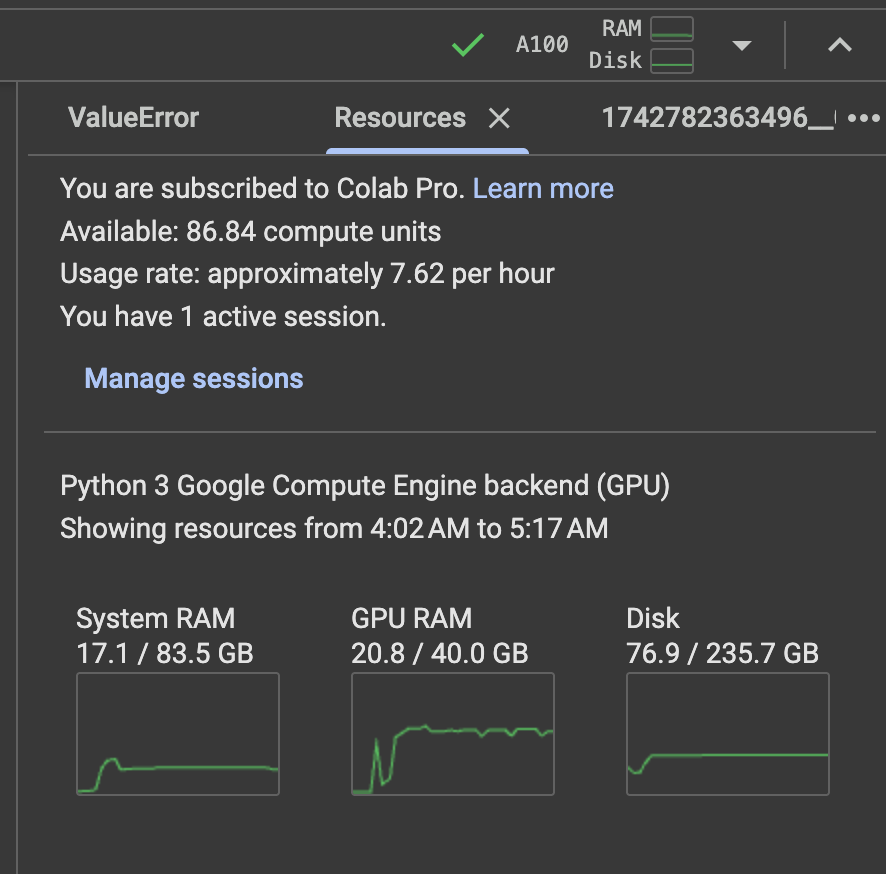